[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/bayes_pydata_london_2024/blob/master/pymc_intro.ipynb)

# Building Models in PyMC


Probabilistic programming (PP) allows flexible specification of Bayesian statistical models in code. PyMC is an open-source PP framework with an intuitive and readable, yet powerful, syntax that is close to the natural syntax statisticians use to describe models. It features next-generation Markov chain Monte Carlo (MCMC) sampling algorithms such as the No-U-Turn Sampler (NUTS; Hoffman, 2014), a self-tuning variant of Hamiltonian Monte Carlo (HMC; Duane, 1987). This class of samplers works well on high dimensional and complex posterior distributions and allows many complex models to be fit without specialized knowledge about fitting algorithms. HMC and NUTS take advantage of gradient information from the likelihood to achieve much faster convergence than traditional sampling methods, especially for larger models. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo, which means you usually don't need to have specialized knowledge about how the algorithms work. 

Let's start by looking at a **marketing** problem, to give you an idea of how to build a model in PyMC.

Based on https://juanitorduz.github.io/pymc_mmm/ by Juan Orduz, which follows the strategy outlined in Google's paper [Jin, Yuxue, et al. “Bayesian methods for media mix modeling with carryover and shape effects.” (2017)](https://research.google/pubs/pub46001/).


In [1]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pytensor.tensor as pt
from sklearn.preprocessing import MaxAbsScaler

random_seed = 42
DATA_URL = "https://raw.githubusercontent.com/fonnesbeck/bayes_pydata_london_2024/master/data/"

## Example: Media Effect Estimation

A fundamental problem for any business is to evaluate the effectiveness of its marketing campaigns. In this example, we will use PyMC to estimate the effect of varying amounts of marketing media spend on sales.

We start by reading the data. This `csv` was generated in the post [Media Effect Estimation with Orbit's KTR Model](https://juanitorduz.github.io/orbit_mmm/), please refer to it for details. Here we give a quick overview of the data.

In [2]:
cols = ["date", "year", "month", "dayofyear", "z", "y"]
try:
    ktr_data = pd.read_csv('./data/ktr_data.csv', parse_dates=['date'], usecols=cols)
except FileNotFoundError:
    ktr_data = pd.read_csv(DATA_URL + 'ktr_data.csv', parse_dates=['date'], usecols=cols)
ktr_data = ktr_data.rename(columns={'z': 'spend', 'y': 'sales'})
ktr_data.head()

,date,year,month,dayofyear,spend,sales
0,2018-04-02,2018,4,92,0.936350,3.865978
1,2018-04-09,2018,4,99,9.507143,4.446291
2,2018-04-16,2018,4,106,7.319939,4.593694
3,2018-04-23,2018,4,113,5.986585,4.639861
4,2018-04-30,2018,4,120,0.390047,4.341417


Let us now plot the most relevant variables for the analysis:

1. The first plot is our target variable `y`, which can represent sales data, for example.
2. The second plot is the input data `z` which is something we have control of.

At first glance, there does not seem to be an obvious relationship between the amount of money spent on advertising and sales. But let's start by constructing a **regression model** and go from there.

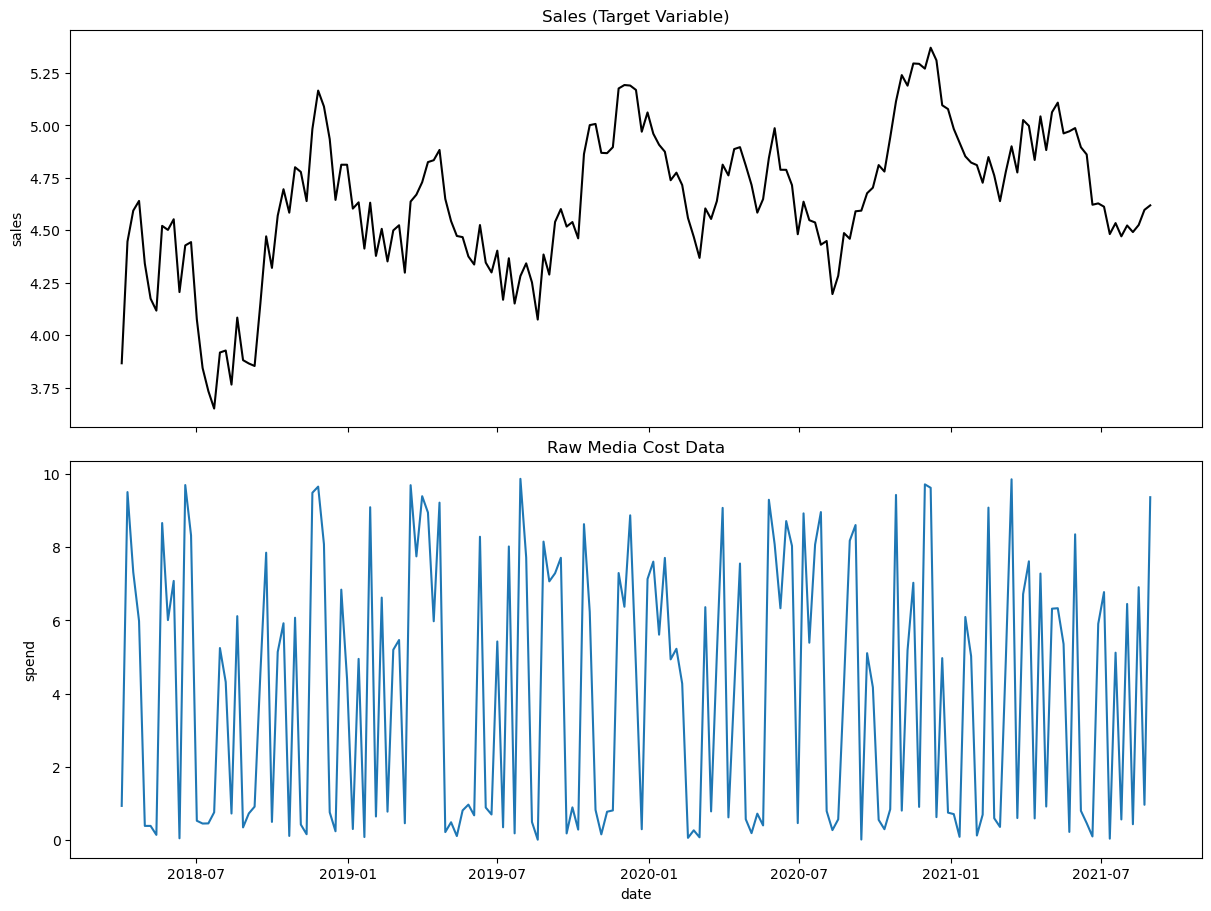

In [3]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 9),
    sharex=True,
    sharey=False,
    layout="constrained"
)
sns.lineplot(x="date", y="sales", color="black", data=ktr_data, ax=ax[0])
ax[0].set(title="Sales (Target Variable)")
sns.lineplot(x="date", y="spend", data=ktr_data, ax=ax[1])
ax[1].set(title="Raw Media Cost Data");

We can extract the target and features as `numpy` arrays for use in PyMC.

In [4]:
sales = ktr_data["sales"].to_numpy()
spend = ktr_data["spend"].to_numpy()
n_obs = sales.size

## Scaling

We scale both the target variable `sales` and the channel input `spend`  using a `MaxAbsScaler`. Throughout our analysis, we carefully study the effect of these scalers and describe how to recover the predictions and effects back to the original scale.

One might be tempted to use a `MinMaxScaler` here. However, this would cause a problem when computing some quantities of interest. For example, we may want to set the media cost to $0$ in the raw data scale and generate in-sample predictions. The problem arises when the media data never reaches $0$. In this case, when using a `MaxAbsScaler`, the zero value of the transformed variable represents the minimum value of the original variable. Hence, when setting the media cost to $0$, the transformed variable would be less than zero. Therefore, we use a `MaxAbsScaler`, which ensures that the zero in the transformed variable is the zero in the original variable.

In [5]:
endog_scaler = MaxAbsScaler()
endog_scaler.fit(sales.reshape(-1, 1))
sales_scaled = endog_scaler.transform(sales.reshape(-1, 1)).flatten()

channel_scaler = MaxAbsScaler()
channel_scaler.fit(spend.reshape(-1, 1))
spend_scaled = channel_scaler.transform(spend.reshape(-1, 1)).flatten()

## The Model

We are going to fit a linear regression model with a single regressor `spend` and two additional features: a linear trend and a seasonal component. The model is defined as follows:

$$
\mathbb{E}[\text{sales}] = \mu + \beta \cdot \text{spend}
$$

$$y \sim N(\mathbb{E}[\text{sales}], \sigma)$$




### Stochastic and Deterministic Variables

At the model-specification stage (before the data are observed), $\mu_1$, $\mu_2$, $\tau$ and $\sigma$ are all random variables. Bayesian "random" variables have not necessarily arisen from a physical random process. The Bayesian interpretation of probability is **epistemic**, meaning random variable $x$'s probability distribution $p(x)$ represents our knowledge and uncertainty about $x$'s value. Candidate values of $x$ for which $p(x)$ is high are relatively more probable, given what we know. 

We can generally divide the variables in a Bayesian model into two types: **stochastic** and **deterministic**. For example, the expected value of sales in the model is the sum of the trend, seasonality and spend effect. If we know the values of these components, we could compute the expected value *exactly*. A deterministic is defined by a mathematical function that returns its value given values for its parents. Deterministic variables are sometimes called the *systemic* part of the model. The nomenclature is a bit confusing, because these objects usually represent random variables; since the parents of the expected value are random, the expected value is random also.

On the other hand, even if the values of the parents of $\mu$, for example, were known, we would still be uncertain of its value. Such variables are **stochastic**, characterized by probability distributions that express how plausible their candidate values are, given values for their parents.

We will assign the following **prior distributions** to our stochastic variables:

$$\mu \sim \text{Normal}(0, 4)$$

$$\beta \sim \text{HalfNormal}(2)$$

$$\sigma \sim \text{HalfNormal}(0.5)$$

We use a [`pm.HalfNormal`](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.HalfNormal.html) distribution for the media coefficients to ensure they are positive.

## Implementation

Now that we have written the model down completely, let's turn it into PyMC code. We will walk through it step-by-step, from specifying our prior distributions through to the data likelihoods.

In [6]:
with pm.Model() as ad_spend_model:

    ## intercept
    mu = pm.Normal(name="mu", mu=0, sigma=4)

    ## spend effect
    beta = pm.HalfNormal(name="beta", sigma=2)

We have done two things here. First, we have created a `Model` object; a `Model` is a Python object that encapsulates all of the variables that comprise our theoretical model, keeping them in a single container so that they may be used as a unit. After a `Model` is created, we can populate it with all of the model components that we specified when we wrote the model down. 

Notice that the `Model` above was declared using a `with` statement. This expression is used to define a Python idiom known as a **context manager**. Context managers, in general, are used to manage resources of some kind within a program. In this case, our resource is a `Model`, and we would like to add variables to it so that we can fit our statistical model. The key characteristic of the context manager is that the resources it manages are only defined within the indented block corresponding to the `with` statement. PyMC uses this idiom to automatically add defined variables to a model. Thus, any variable we define is automatically added to the `Model`, without having to explicitly add it.

As an analogy, `Model` is a tape machine that records what is being added to the model; it keeps track the random variables (observed or unobserved) and other model components. The model context then computes some simple model properties, builds a **bijection** mapping that transforms between Python dictionaries and numpy/Aesara ndarrays. , More importantly, a `Model` contains methods to compile Aesara functions that take Random Variables--that are also initialised within the same model--as input.

In fact, PyMC variables cannot be defined without a corresponding `Model`:

In [7]:
x = pm.Normal("x", mu=0, sigma=10)

TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.

A stochastic variable is represented in PyMC by a `Distribution` class. This structure extens PyTensor's `TensorVariable` class, mainly by registering it with an associated PyMC `Model`. 

In [8]:
type(mu)

pytensor.tensor.variable.TensorVariable

All of the `Distribution` subclasses included in PyMC will have two key methods, `random()` and `logp()`, which are used to generate random values and compute the log-probability of a value, respectively.

```python
class SomeDistribution(Continuous):
    def __init__(...):
        ...

    def random(self, point=None, size=None):
        ...
        return random_samples

    def logp(self, value):
        ...
        return total_log_prob
```

PyMC expects the `logp()` method to return a log-probability evaluated at the passed `value` argument. This method is used internally by all of the inference methods to calculate the model log-probability that is used for fitting models. 

The `logp` method is only used internally by PyMC; should you wish to calculate a log-probability manually, use the `pm.logp` function instead:

In [9]:
pm.logp(mu, 5).eval()

array(-3.0864829)

The `random()` method is used to simulate values from the variable, and is used internally for posterior predictive checks. Similarly, to manually generate values from PyMC variables, use the `pm.draw` function:

In [10]:
pm.draw(mu, 5)

array([ 0.67277753,  0.10691247,  3.86155604, -2.83088501, -4.19438288])

`Distribution` has a classmethod `dist` that returns a **stateless** probability distribution of that type; that is, without being wrapped in a PyMC random variable object. Sometimes we wish to use a particular statistical distribution, without using it as a variable in a model; for example, to generate random numbers from the distribution. 

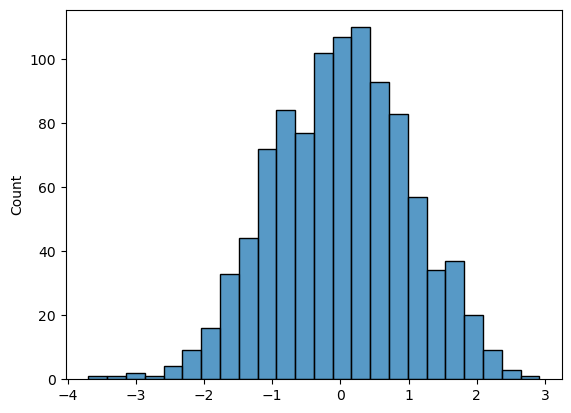

In [11]:
x = pm.Normal.dist(mu=0, sigma=1, size=1000)
sns.histplot(x.eval());

PyMC includes most of the probability density functions (for continuous variables) and probability mass functions (for discrete variables) used in statistical modeling. These distributions are divided into five distinct categories:

* Univariate continuous
* Univariate discrete
* Multivariate
* Mixture
* Timeseries

Probability distributions are all subclasses of `Distribution`, which in turn has two major subclasses: `Discrete` and `Continuous`. In terms of data types, a `Continuous` random variable is given whichever floating point type is defined by `aesara.config.floatX`, while `Discrete` variables are given `int16` types when `aesara.config.floatX` is `float32`, and `int64` otherwise.

In [12]:
pm.distributions.__all__

['AR',
 'CAR',
 'GARCH11',
 'ICAR',
 'AsymmetricLaplace',
 'Bernoulli',
 'Beta',
 'BetaBinomial',
 'Binomial',
 'Categorical',
 'Cauchy',
 'Censored',
 'ChiSquared',
 'Continuous',
 'CustomDist',
 'DensityDist',
 'DiracDelta',
 'Dirichlet',
 'DirichletMultinomial',
 'Discrete',
 'DiscreteUniform',
 'DiscreteWeibull',
 'Distribution',
 'EulerMaruyama',
 'ExGaussian',
 'Exponential',
 'Flat',
 'Gamma',
 'GaussianRandomWalk',
 'Geometric',
 'Gumbel',
 'HalfCauchy',
 'HalfFlat',
 'HalfNormal',
 'HalfStudentT',
 'HurdleGamma',
 'HurdleLogNormal',
 'HurdleNegativeBinomial',
 'HurdlePoisson',
 'HyperGeometric',
 'Interpolated',
 'InverseGamma',
 'KroneckerNormal',
 'Kumaraswamy',
 'LKJCholeskyCov',
 'LKJCorr',
 'Laplace',
 'LogNormal',
 'Logistic',
 'LogitNormal',
 'Lognormal',
 'MatrixNormal',
 'Mixture',
 'Moyal',
 'Multinomial',
 'MvGaussianRandomWalk',
 'MvNormal',
 'MvStudentT',
 'MvStudentTRandomWalk',
 'NegativeBinomial',
 'Normal',
 'NormalMixture',
 'OrderedLogistic',
 'OrderedMultin

While we are defining our priors, let's also add the prior for `sigma`, the observation noise parameter.

In [13]:
with ad_spend_model:

    sigma = pm.HalfNormal("sigma", 0.5)

Notice that we have "re-opened" the `spin_rate_model` in a new context manager, which allows us to add additional variables.

Internally, the model is keeping track of the types of variables that are being added:

In [14]:
ad_spend_model.unobserved_RVs

[mu ~ Normal(0, 4), beta ~ HalfNormal(0, 2), sigma ~ HalfNormal(0, 0.5)]

### Auto-transformation

To support efficient sampling by PyMC's MCMC algorithms, any continuous variables that are constrained to a sub-interval of the real line are automatically transformed so that their support is unconstrained. This frees sampling algorithms from having to deal with boundary constraints.

For example, the half-normal distribution is positive-valued.

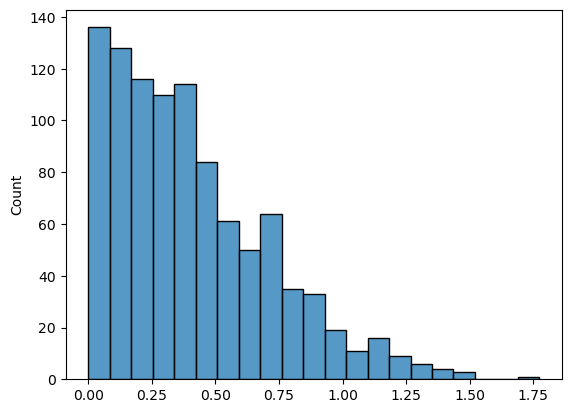

In [15]:
sns.histplot(pm.draw(sigma, 1000));

In [16]:
pm.logp(sigma, -1).eval()

array(-inf)

If we inspect the model's `value_vars` attribute, which contains the values of each random variable actually used by the model's log-likelihood:


In [17]:
ad_spend_model.value_vars

[mu, beta_log__, sigma_log__]

As the name suggests, the variable `sigma` has been log-transformed, and this is the space over which posterior sampling takes place. When a sample is drawn, the value of the transformed variable is simply back-transformed to recover the original variable.

By default, auto-transformed variables are ignored when summarizing and plotting model output, since they are not generally of interest to the user.

## Deterministic Variables

A deterministic variable is one whose values are **completely determined** by the values of their parents.

In [18]:
with ad_spend_model:

    expected_sales = mu + beta * spend_scaled

The values of `expected_sales` are assigned based on the values of `mu` and `beta` only, with no inherent randomness beyond what is inherited from them. 

Notice that `expected_sales` is **anonymous** as it has not been given a name or a formal PyMC data structure, like the stochastic priors have. It is essentially an **intermediate calculation** in the model, implying that we are not interested in its value when it comes to summarizing the output from the model. Most PyMC objects have a name assigned; these names are used for storage and post-processing:

-   as keys in output databases,
-   as axis labels in plots of traces,
-   as table labels in summary statistics.

If we wish to include `expected_sales` in our output, we need to make it a `Deterministic` object, and give it a name:

```python
with ad_spend_model:

    expected_sales = pm.Deterministic('expected_sales', mu + beta * spend)
```

## Observed Random Variables

Stochastic random variables whose values are observed (*i.e.* data likelihoods) are represented by a different class than unobserved random variables. A `ObservedRV` object is instantiated any time a stochastic variable is specified with data passed as the `observed` argument. 

In [19]:
with ad_spend_model:

    pm.Normal(name="likelihood", mu=expected_sales, sigma=sigma, observed=sales_scaled)

In [20]:
ad_spend_model.observed_RVs

[likelihood ~ Normal(f(mu, beta), sigma)]

An important responsibility of `ObservedRV` is to automatically handle missing values in the data, when they are present (absent?). 

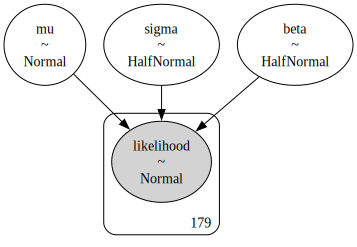

In [21]:
pm.model_to_graphviz(model=ad_spend_model)

We now have a complete linear regression model. Let's put it in a single cell for clarity, and wrap it in a function for reusability.

In [22]:
def make_model():

    with pm.Model() as ad_spend_model:

        ## intercept
        mu = pm.Normal(name="mu", mu=0, sigma=4)

        ## spend effect
        beta = pm.HalfNormal(name="beta", sigma=2)

        expected_sales = pm.Deterministic("expected_sales", mu + beta * spend_scaled)

        # Observation noies
        sigma = pm.HalfNormal("sigma", 0.5)

        # Data likelihood
        pm.Normal(name="likelihood", mu=expected_sales, sigma=sigma, observed=sales_scaled)

    return ad_spend_model

Now it's time to fit the model with MCMC.

## `sample`

The user's interface to PyMC's sampling algorithms is the `sample` function. There is a large set of input parameters, all of which are optional with reasonable defaults, but here are the most common ones that you may want to modify:

```python
pm.sample(
    draws: int = 1000,
    *,
    tune: int = 1000,
    chains: int | None = None,
    cores: int | None = None,
    random_seed: None | int | collections.abc.Sequence[int] | numpy.ndarray | numpy.random.mtrand.RandomState | numpy.random._generator.Generator = None,
    progressbar: bool = True,
    progressbar_theme: rich.theme.Theme | None = <rich.theme.Theme object at 0x7fb6d141dd90>,
    step=None,
    var_names: collections.abc.Sequence[str] | None = None,
    nuts_sampler: Literal['pymc', 'nutpie', 'numpyro', 'blackjax'] = 'pymc',
    initvals: dict[pytensor.graph.basic.Variable | str, numpy.ndarray | pytensor.graph.basic.Variable | str] | collections.abc.Sequence[dict[pytensor.graph.basic.Variable | str, numpy.ndarray | pytensor.graph.basic.Variable | str] | None] | None = None,
    init: str = 'auto',
    jitter_max_retries: int = 10,
    n_init: int = 200000,
    trace: pymc.backends.base.BaseTrace | None = None,
    discard_tuned_samples: bool = True,
    compute_convergence_checks: bool = True,
    keep_warning_stat: bool = False,
    return_inferencedata: bool = True,
    idata_kwargs: dict[str, typing.Any] | None = None,
    nuts_sampler_kwargs: dict[str, typing.Any] | None = None,
    callback=None,
    mp_ctx=None,
    blas_cores: Union[int, NoneType, Literal['auto']] = 'auto',
    model: pymc.model.core.Model | None = None,
    **kwargs,
) -> arviz.data.inference_data.InferenceData | pymc.backends.base.MultiTrace
```

`sample` assigns particular samplers to model variables, and generates samples from them. 

PyMC can automate most of the details of sampling using default settings for several parameters that control how the sampling is set up and conducted. However, users may manually intervene in the specification of the sampling by passing values to a number of keyword argumetns for `sample`.

Most commonly, the `draws` argument that 
controls the total number of MCMC iterations and the `tune` argument that controls the number of additional tuning steps to perform, are modified by the user depending on the model being fit.

### Assigning sampling algorithm

The `step` argument allows users to manually assign a MCMC sampling algorithm to the entire model, or to a subset of the variables in the model. For example, if we wanted to use the Metropolis-Hastings sampler to fit our model, we could pass an instance of that step method to `sample` via the `step` argument:

```python
with ad_spend_model:

    trace = pm.sample(1000, step=pm.Metropolis())
```

or if we only wanted to assign `Metropolis` to a subset of our parameters:

```python
with ad_spend_model:

    trace = pm.sample(1000, step=pm.Metropolis(vars=[alpha, delta]))
```

When `step` is not specified by the user, PyMC will assign step methods to variables automatically. To do so, each step method implements a class method called `Competence`. This method returns a value from 0 (incompatible) to 3 (ideal), based on the attributes of the random variable in question. `sample()` assigns the step method that returns the highest competence value to each of its unallocated stochastic random variables. In general:

* Binary variables will be assigned to `BinaryMetropolis` (Metropolis-Hastings for binary values)
* Discrete variables will be assigned to `Metropolis`
* Continuous variables will be assigned to `NUTS` (No U-turn Sampler)

### Starting values

The `initvals` argument allows for the specification of starting values for stochastic random variables in the model. MCMC algorithms begin by initializing all unknown quantities to arbitrary starting values. Though in theory the value can be any value under the support of the distribution describing the random variable, we can make sampling more difficult if an initial value is chosen in the extreme tail of the distribution, for example. 

If starting values are not passed by the user (`intivals=None`), default values are chosen from the mean, median or mode of the distribution.

In [23]:
ad_spend_model.initial_point()

{'mu': array(0.),
 'beta_log__': array(0.69314718),
 'sigma_log__': array(-0.69314718)}

In [24]:
with make_model():

    initval_trace = pm.sample(draws=500, tune=0, step=pm.Metropolis(), initvals={'mu':-30})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [beta]
>Metropolis: [sigma]


Output()

Sampling 4 chains for 0 tune and 500 draw iterations (0 + 2_000 draws total) took 23 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


The ArviZ function `plot_trace` is a useful exploratory tool for examining the resulting samples, which we refer to as a *trace*. On the left is a set of histograms (one for each chain) and on the right is a time series plot of the chains in the order they were drawn.

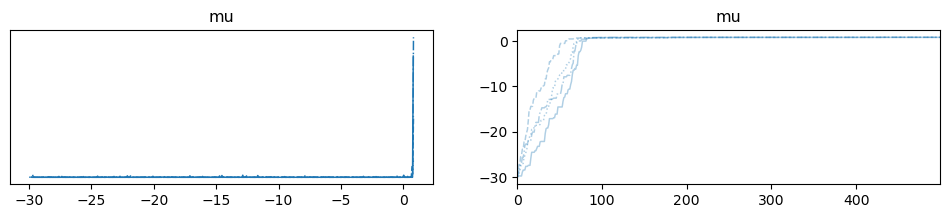

In [25]:
az.plot_trace(initval_trace, var_names=["mu"]);

This example was deliberately poor, showing the movement away from the initial values, but each of the chains appear to be stuck in different regions of the parameter space. This model needs tuning!

Let's tune the model and generate some results ...

In [53]:
with make_model() as ad_spend_model:

    trace = pm.sample(10000, tune=1000, random_seed=random_seed)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 38 seconds.


You likely saw some warnings after running the model as specified above. We will dig into these warnings a bit later.

Let's have a peek at some of the parameters of interest. The [ArviZ](https://github.com/arviz-devs/arviz) package allows us to easily plot the posterior estimates. 

For univariate variables, a *posterior plot* can be used to inspect the posterior distribution.

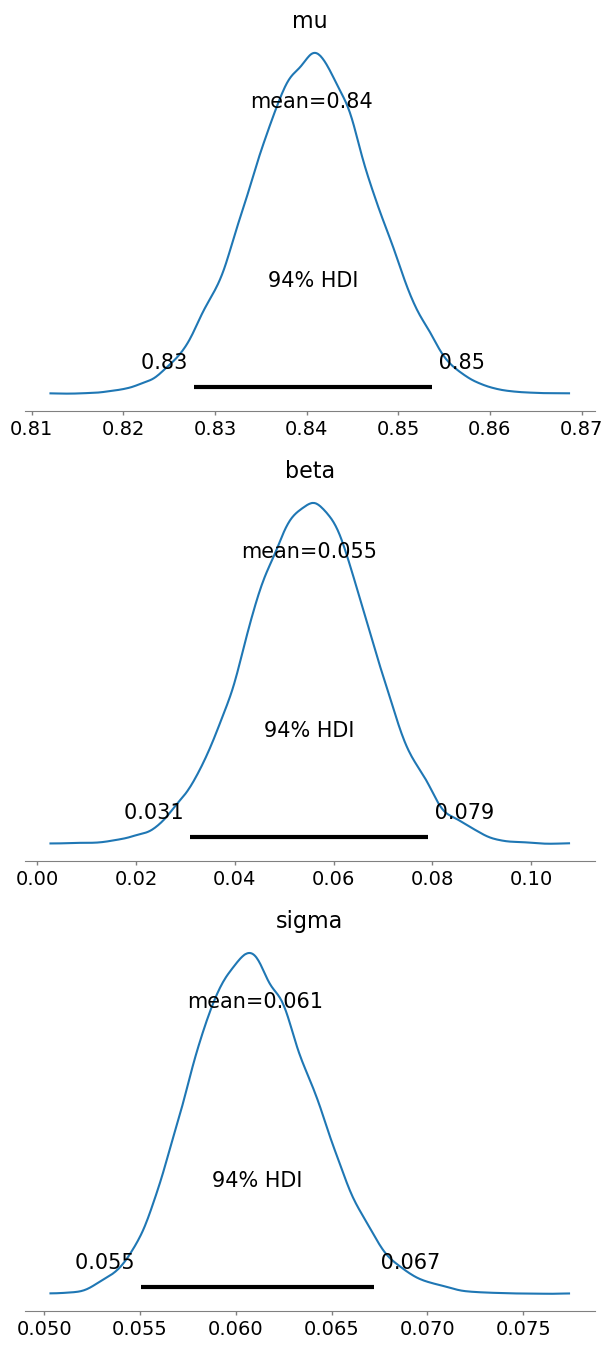

In [54]:
az.plot_posterior(trace, var_names=["mu", "beta", "sigma"], grid=(3, 1));

Remember, the sales data were scaled by the maximum absolute value, so the parameters can be inverse-transformed to their original scale:

In [55]:
endog_scaler.inverse_transform([[0.12]])

array([[0.64442111]])

### Storing samples

Notice in the above call to `sample` that output is assigned to a variable we have called `trace`. 

In [56]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

This `InferenceData` object is a data structure that stores the samples from an MCMC run as grouped attributes. The data structure itself is an `xarray.Dataset` object, which is a dictionary-like object that stores the samples in a multi-dimensional array.

The xarray components include:

- **Data variables** are the actual values generated from the MCMC draws
- **Dimensions** are the axes on which refer to the data variables
- **Coordinates** are pointers to specific slices or points in the `xarray.Dataset`

### Parallel sampling

Nearly all modern desktop computers have multiple CPU cores, and running multiple MCMC chains is an **embarrasingly parallel** computing task. It is therefore relatively simple to run chains in parallel in PyMC. This is done by setting the `cores` argument in `sample` to some value between 2 and the number of cores on your machine (you can specify more chains than cores, but you will not gain efficiency by doing so). 

> Keep in mind that some chains might themselves be multithreaded via openmp or BLAS. In those cases it might be faster to set this to 1.

By default, PyMC will run a sample a minimum of 2 and a maximum of `cores` chains. However, the number of chains sampled can be set independently of the number of cores by specifying the `chains` argument.

In [58]:
with make_model():
    ptrace = pm.sample(1000, chains=4, cores=4)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


Running $n$ iterations with $c$ chains will result in $c \times n$ samples.

In [59]:
ptrace.posterior['mu'].shape

(4, 1000)

Generating several chains is generally recommended because it aids in model checking, allowing statistics such as the potential scale reduction factor ($\hat{R}$) and effective sample size to be calculated.


# Model Checking

After running an MCMC simulation, `sample` returns an `arviz.InferenceData` object containing the samples for all the stochastic and named deterministic random variables. The final step in Bayesian computation is model checking, in order to ensure that inferences derived from your sample are valid. There are two components to model checking:

1. Convergence diagnostics
2. Goodness of fit

Convergence diagnostics are intended to detect lack of convergence in the Markov chain Monte Carlo sample; it is used to ensure that you have not halted your sampling too early. However, a converged model is not guaranteed to be a good model. The second component of model checking, goodness of fit, is used to check the internal validity of the model, by comparing predictions from the model to the data used to fit the model. 

## Convergence Diagnostics

### Gazing at Sample Trace

The most straightforward approach for assessing convergence is based on
simply **plotting and inspecting traces and histograms** of the observed
MCMC sample. If the trace of values for any of the stochastic variables displays lack of stationarity or homogeneity, this may be evidence of lack of convergence.

In [51]:
with make_model():

    bad_trace = pm.sample(1000, tune=10, chains=2, random_seed=random_seed)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, beta, sigma]


Output()

Sampling 2 chains for 10 tune and 1_000 draw iterations (20 + 2_000 draws total) took 10 seconds.
There were 1099 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


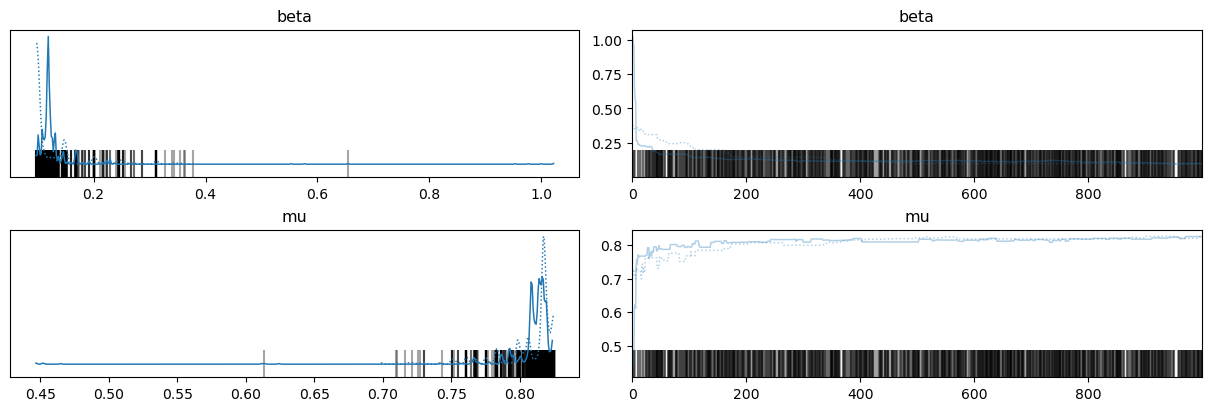

In [52]:
az.plot_trace(bad_trace, var_names=['beta', 'mu'], backend_kwargs=dict(constrained_layout=True));

In comparison, here are traces from the full run with 1000 samples after 1000 tuning iterations.

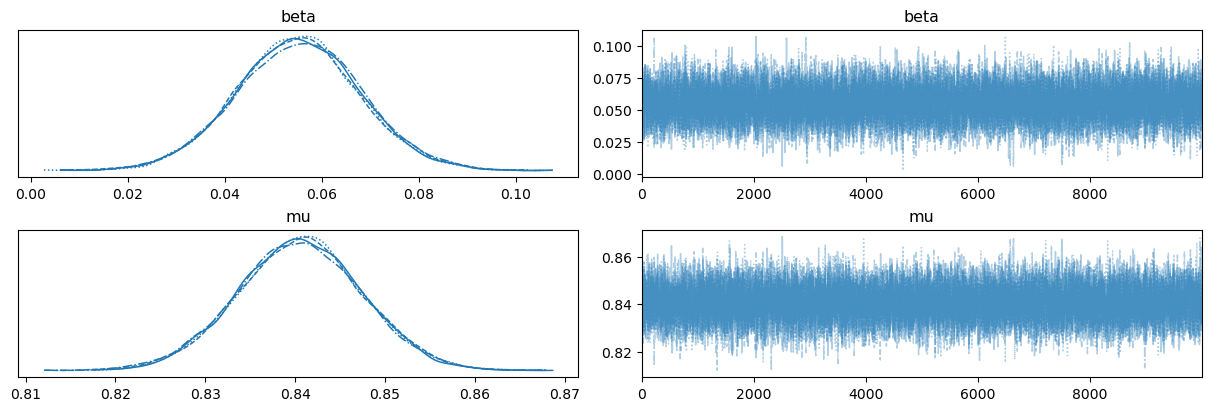

In [60]:
az.plot_trace(trace, var_names=['beta', 'mu'], backend_kwargs=dict(constrained_layout=True));

### Divergences

During some of the MCMC runs above, you may have noticed warnings about divergnces:

    There were 1236 divergences after tuning. Increase `target_accept` or reparameterize.

You will see these divergences identified in the output of `plot_trace` as black lines along the x-axis.

Hamiltonian Monte Carlo (and NUTS) performs numerical integration in order to explore the posterior distribution of a model. When the integration goes wrong, it can go dramatically wrong.

For example, here are some Hamiltonian trajectories on the distribution of two correlated variables. Can you spot the divergent path?

![](assets/diverging_hmc.png)

The reason that this happens is that there may be parts of the posterior which are hard to explore for geometric reasons. Two ways of solving divergences are

1. **Set a higher `target accept` rate**: Similarly (but not the same) as for Metropolis-Hastings, larger integrator steps lead to lower acceptance rates. A higher `target_accept` will generally cause a smaller step size, and more accurate integration, but result in longer run times.
2. **Reparametrize**: If you can write your model in a different way that has the same joint probability density, you might do that. A lot of work is being done to automate this, since it requires careful work, and one goal of a probabilistic programming language is to iterate quickly. 
   
   
You should be wary of a trace that contains many divergences (particularly those clustered in particular regions of the parameter space), and attempt to fix them.

### Potential Scale Reduction: $\hat{R}$

Roughly, $\hat{R}$ (*R-Hat*, or the *potential scale reduction factor*) is the ratio of between-chain variance to within-chain variance. This diagnostic uses multiple chains to
check for lack of convergence, and is based on the notion that if
multiple chains have converged, by definition they should appear very
similar to one another; if not, one or more of the chains has failed to
converge.

$\hat{R}$ uses an analysis of variance approach to
assessing convergence. That is, it calculates both the between-chain
varaince (B) and within-chain varaince (W), and assesses whether they
are different enough to worry about convergence. Assuming $m$ chains,
each of length $n$, quantities are calculated by:

$$\begin{align}B &= \frac{n}{m-1} \sum_{j=1}^m (\bar{\theta}_{.j} - \bar{\theta}_{..})^2 \\
W &= \frac{1}{m} \sum_{j=1}^m \left[ \frac{1}{n-1} \sum_{i=1}^n (\theta_{ij} - \bar{\theta}_{.j})^2 \right]
\end{align}$$

for each scalar estimand $\theta$. Using these values, an estimate of
the marginal posterior variance of $\theta$ can be calculated:

$$\hat{\text{Var}}(\theta | y) = \frac{n-1}{n} W + \frac{1}{n} B$$

Assuming $\theta$ was initialized to arbitrary starting points in each
chain, this quantity will overestimate the true marginal posterior
variance. At the same time, $W$ will tend to underestimate the
within-chain variance early in the sampling run. However, in the limit
as $n \rightarrow 
\infty$, both quantities will converge to the true variance of $\theta$.
In light of this, $\hat{R}$ monitors convergence using
the ratio:

$$\hat{R} = \sqrt{\frac{\hat{\text{Var}}(\theta | y)}{W}}$$

This is called the **potential scale reduction**, since it is an estimate of
the potential reduction in the scale of $\theta$ as the number of
simulations tends to infinity. In practice, we look for values of
$\hat{R}$ close to one (say, less than 1.1) to be confident that a
particular estimand has converged. 

In ArViZ, the `summary` table, or a `plot_forest` with the `r_hat` flag set, will calculate $\hat{R}$ for each stochastic node in the trace.

In [61]:
az.summary(trace, var_names=["mu", "beta", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.841,0.007,0.828,0.854,0.0,0.0,19581.0,19892.0,1.0
beta,0.055,0.013,0.031,0.079,0.0,0.0,18814.0,17671.0,1.0
sigma,0.061,0.003,0.055,0.067,0.0,0.0,24470.0,24768.0,1.0



## Goodness of Fit

As noted at the outset, convergence diagnostics are only the first step in the evaluation
of MCMC model outputs. It is possible for an entirely unsuitable model to converge to something, so additional steps are needed to ensure that the estimated model adequately fits the data. 

One intuitive way of evaluating model fit is to compare model predictions with the observations used to fit
the model. In other words, the fitted model can be used to simulate data, and the distribution of the simulated data should resemble the distribution of the actual data.

Fortunately, simulating data from the model is a natural component of the Bayesian modelling framework. Recall, from the discussion on prediction, the posterior predictive distribution:

$$p(\tilde{y}|y) = \int p(\tilde{y}|\theta) f(\theta|y) d\theta$$

Here, $\tilde{y}$ represents some hypothetical new data that would be expected, taking into account the posterior uncertainty in the model parameters. 

Sampling from the posterior predictive distribution is easy in PyMC. The `sample_posterior_predictive` function draws posterior predictive samples from all of the observed variables in the model.

In [62]:
with ad_spend_model:

    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [likelihood]


Output()

This generates draws that account both for the residual posterior uncertainty of the model parameters and the stochastic variability of the sampling distribution.

Setting the `extend_inferencedata` flag will append the resulting samples to the trace that is passed in, adding a `posterior_predictive` node to the trace.

In [63]:
trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

It is easiest to evaluate the calibration of the model visually, using the `plot_ppc` function. This plots the posterior predictive samples (and the mean prediction) relative to the observed data.

c:\Users\nazmievairat\anaconda3\envs\pymc_env\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\nazmievairat\anaconda3\envs\pymc_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


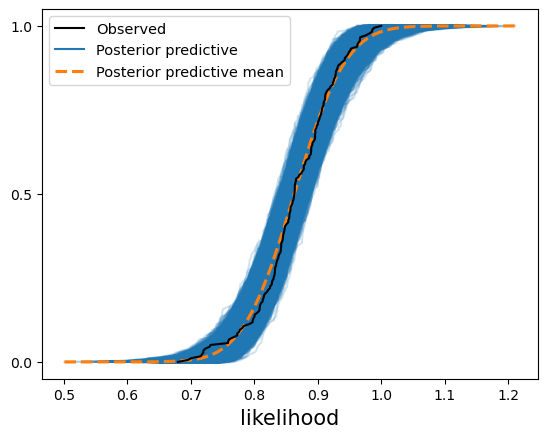

In [64]:
az.plot_ppc(trace, kind='cumulative');

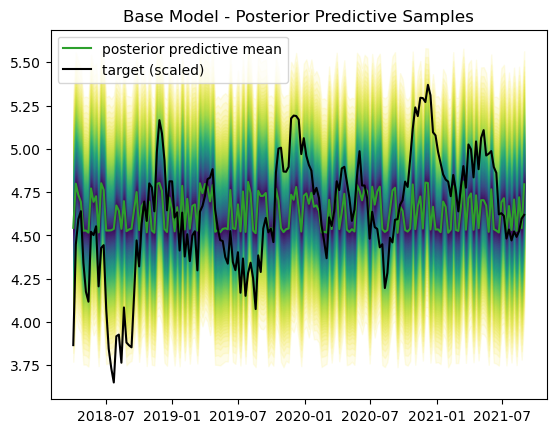

In [65]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))

date = ktr_data["date"].to_numpy()

posterior_predictive_likelihood = az.extract(
    data=trace,
    group="posterior_predictive",
    var_names="likelihood",
)

posterior_predictive_likelihood_inv = endog_scaler.inverse_transform(
    X=posterior_predictive_likelihood
)

fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_inv, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_inv, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date,
    y=posterior_predictive_likelihood_inv.mean(axis=1),
    color="C2",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date,
    y=sales,
    color="black",
    label="target (scaled)",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Base Model - Posterior Predictive Samples");

We will dig into how PyMC fits the model in the next section, but it is clear that we need to improve the model to better predict the target variable!

---

## To Learn More

- C.D. Pilon. [Probabilistic Programming & Bayesian Methods for Hackers](https://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)
- M.I. Jordan. 2004. Graphical models. Statist. Sci., 19(1):140–155.
- **Michael Betancourt**'s [A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434)
- **Hoffman, M. D., and A. Gelman. (2014)**. The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo. Journal of Machine Learning Research: JMLR 15 (1): 1593–1623.
- [Hamiltonian Monte Carlo from Scratch](https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/), by **Colin Carroll**
- **Gelman, A., & Rubin, D. B.** (1992). Inference from iterative simulation using multiple sequences. Statistical Science. A Review Journal of the Institute of Mathematical Statistics, 457–472.


In [40]:
%load_ext watermark
%watermark -n -u -v -iv -w

ModuleNotFoundError: No module named 'watermark'